# Foraging

In [45]:
from dynamics import *
from policies import *

np.random.seed(11)

# 1 - Grid

# Grid = 25
# Actions = 6


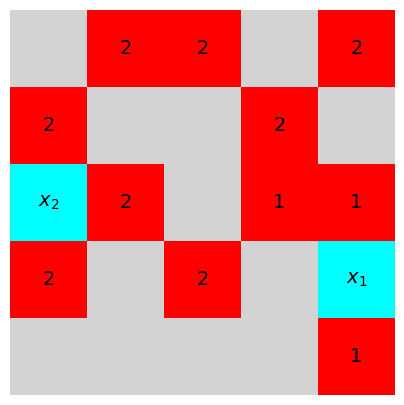

In [46]:
env = LBF2(grid_size=5, n_agents=2, n_apples=11, reward_timestep=-0.1)
GRID_SIZE = np.size(env.grid)
N_ACTIONS = len(env.ACTION_SPACE)

env.render()

print(f'# Grid = {GRID_SIZE}')
print(f'# Actions = {N_ACTIONS}')

In [47]:
env.grid

array([[ 0,  2,  2,  0,  2],
       [ 2,  0,  0,  2,  0],
       [-2,  2,  0,  1,  1],
       [ 2,  0,  2,  0, -1],
       [ 0,  0,  0,  0,  1]])

### **Random Policy**

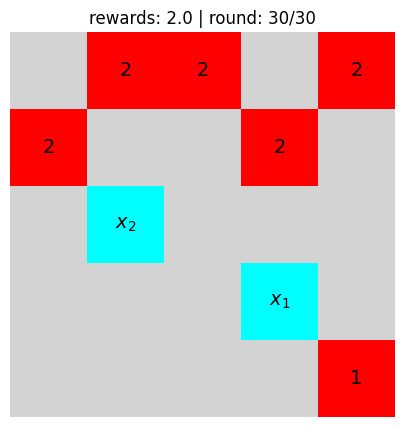

100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


In [48]:
policies = [policy_rand, policy_rand]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=1, show_games=True)

100%|██████████| 100/100 [00:00<00:00, 175.18it/s]

quantiles = [-4 -3 -3 -1  5]


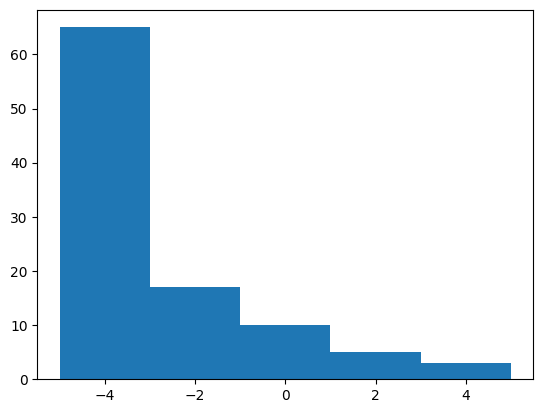

In [7]:
policies = [policy_rand, policy_rand]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=100)
quantiles = np.quantile(V, q=[0,0.25, 0.5, 0.75, 1]).astype(int)
print(f'quantiles = {quantiles}')

plt.hist(V, bins=5)
plt.show()

### **$x_1$ 1-Step Lookahead**

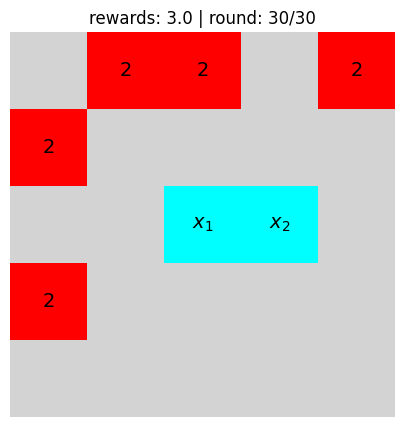

100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


In [16]:
policies = [policy_lookahead, policy_lookahead]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=1, show_games=True)

100%|██████████| 1000/1000 [00:36<00:00, 27.15it/s]

quantiles = [-3 -3 -3  0 11]


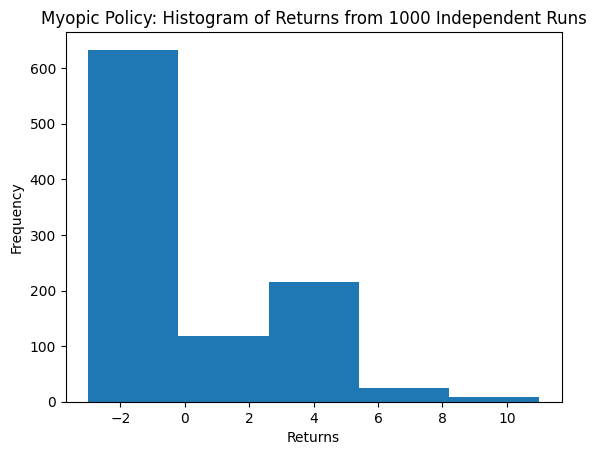

In [36]:
policies = [policy_lookahead, policy_lookahead]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=1000)
quantiles = np.quantile(V, q=[0,0.25, 0.5, 0.75, 1]).astype(int)
print(f'quantiles = {quantiles}')

plt.hist(V, bins=5)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Myopic Policy: Histogram of Returns from 1000 Independent Runs')
plt.show()

### REINFORCE IND.

In [4]:
class PolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            nn.Flatten(start_dim=0, end_dim=-1),

            nn.Linear(25, 25),
            nn.ReLU(),

            nn.Linear(25, N_ACTIONS),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, grid):
        grid = torch.tensor([grid], dtype=torch.float)
        return self.model(grid)

100%|██████████| 700/700 [00:12<00:00, 53.91it/s]
/Users/user1/Desktop/MSc. Machine Learning, Systems and Control/study/Reinforcement Learning/Final Project/policies.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


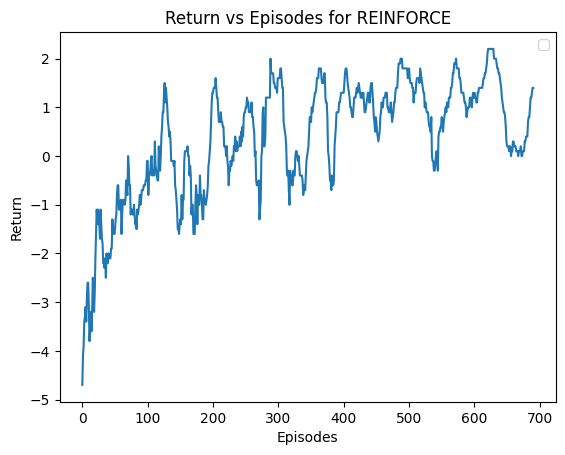

In [41]:
Q = train_REINFORCE(env, PolNet, n_epis=700, n_steps_per_epi=30, lr=0.008, gamma=0.9)

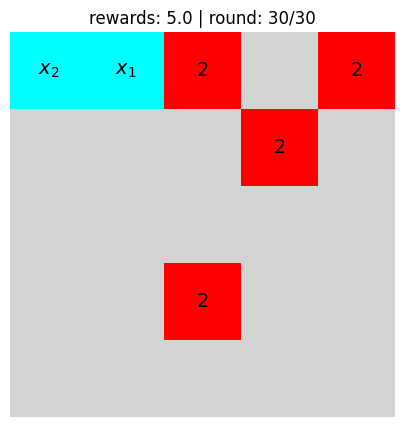

100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


In [42]:
policies = [policy_REINFORCE, policy_REINFORCE]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=1, PolNets=Q, show_games=True)

### REINFORCE Shared Exp.

In [6]:
def generate_trajectory(env, PolNets, n_max=1000):
    
    env.reset()
    trajectory = [{"s":[], "a":[], "probs": [], "s'":[], "r":[]} for _ in range(env.n_agents)] # (state, action, state', reward)
    rewards = 0
    for _ in range(n_max):
        rewards = env.REWARD_TIMESTEP

        for i, agent in enumerate(env.agents):
            curr_state = env.grid
                                
            # Sample Action using Policy Network
            action_probs = PolNets[i](curr_state)
            action_idx = np.random.choice(range(len(env.ACTION_SPACE)), p=action_probs.detach().numpy())
            action = env.ACTION_SPACE[action_idx]
            
            # Transition + Reward
            (reward, terminate) = env.act(agent, action)
            rewards += reward

            trajectory[i]["s"].append(curr_state)
            trajectory[i]["a"].append(action_idx)
            trajectory[i]["probs"].append(action_probs)
            trajectory[i]["s'"].append(env.grid)
            trajectory[i]["r"].append(rewards)
            
            if terminate:
                return trajectory
            
            next_state = env.grid
                
    return trajectory

In [21]:
def train_REINFORCE_shared(env, PolNet, n_epis=100, n_steps_per_epi=1000, lr=0.001, gamma=0.99, lambd=0.5):
    PolNets = [PolNet() for i in range(env.n_agents)]
    optims = [torch.optim.Adam(PolNet.parameters(), lr=lr) for PolNet in PolNets]

    V = []

    for _ in tqdm(range(n_epis)):

        trajectory = generate_trajectory(env, PolNets, n_max=n_steps_per_epi)
        returns = [[] for agent in env.agents]

        for i, agent in enumerate(env.agents):
            for j, s in enumerate(trajectory[i]["s"]):
                G = 0

                for k, r in enumerate(trajectory[i]["r"][j:]):
                    G += (gamma**k)*r

                returns[i].append(G)

        for i, agent in enumerate(env.agents):
            loss = 0
            for j, s in enumerate(trajectory[i]["s"]):
                dist = torch.distributions.Categorical(probs=trajectory[i]["probs"][j])
                prob_other_state = dist.probs[torch.tensor(trajectory[1-i]["a"][j])]
                log_prob = dist.log_prob(torch.tensor(trajectory[i]["a"][j]))
                log_prob_other_state = dist.log_prob(torch.tensor(trajectory[1-i]["a"][j]))

                with torch.no_grad():
                    prob_other = trajectory[1-i]["probs"][j][trajectory[1-i]["a"][j]]
                
                loss += -log_prob*returns[i][j] - lambd * (prob_other_state/prob_other) * log_prob_other_state * returns[1-i][j]
            
            optims[i].zero_grad()
            loss.backward()
            optims[i].step()
                
        V.append(sum(trajectory[0]["r"]))

    plt.title('Return vs Episodes for REINFORCE')
    plt.plot(np.convolve(V, np.ones(20)/20, mode='valid'))
    plt.xlabel('Episodes')
    plt.ylabel('Return')
    plt.legend()

    return PolNets


100%|██████████| 700/700 [00:14<00:00, 49.97it/s]
/var/folders/45/871v_dk90997hj5g88_1z7tr0000gn/T/ipykernel_5253/3099260861.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


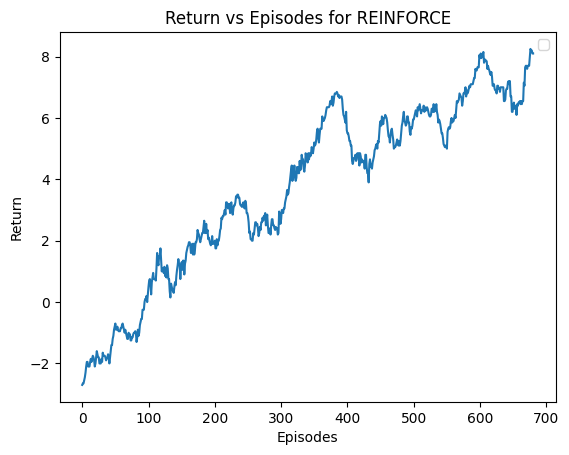

In [39]:
Q_shared = train_REINFORCE_shared(env, PolNet, n_epis=700, n_steps_per_epi=30, lr=0.008, gamma=0.9, lambd=0.01)

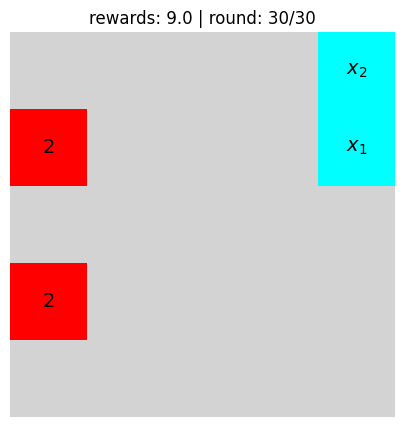

100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


In [40]:
policies = [policy_REINFORCE, policy_REINFORCE]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=1, PolNets=Q_shared, show_games=True)

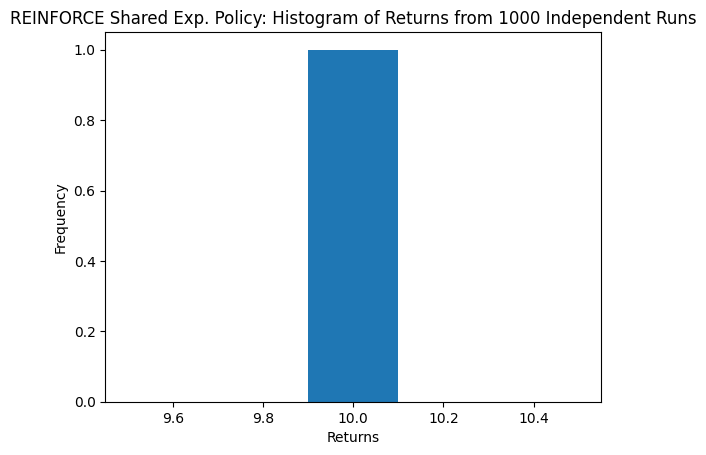

In [37]:

plt.hist(V, bins=5)
plt.title('REINFORCE Shared Exp. Policy: Histogram of Returns from 1000 Independent Runs')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

100%|██████████| 1000/1000 [00:12<00:00, 79.08it/s]


quantiles = [-4  5  8  9 11]


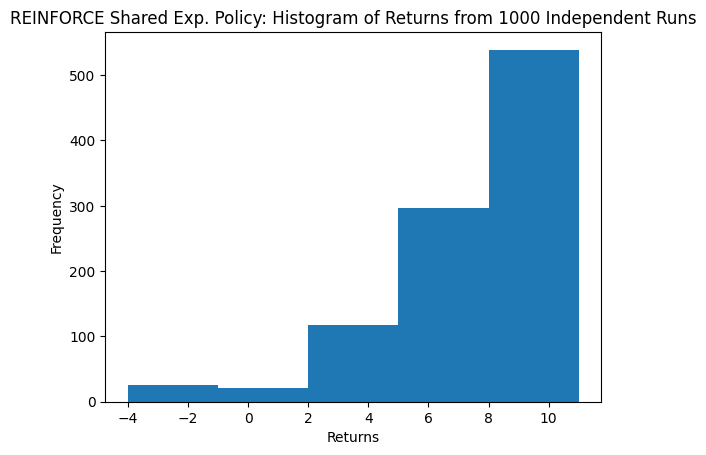

In [38]:
policies = [policy_REINFORCE, policy_REINFORCE]
V = env.simulate(policies, n_steps_per_epi=30, n_epis=1000, PolNets=Q)
quantiles = np.quantile(V, q=[0,0.25, 0.5, 0.75, 1]).astype(int)
print(f'quantiles = {quantiles}')

plt.hist(V, bins=5)
plt.title('REINFORCE Shared Exp. Policy: Histogram of Returns from 1000 Independent Runs')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

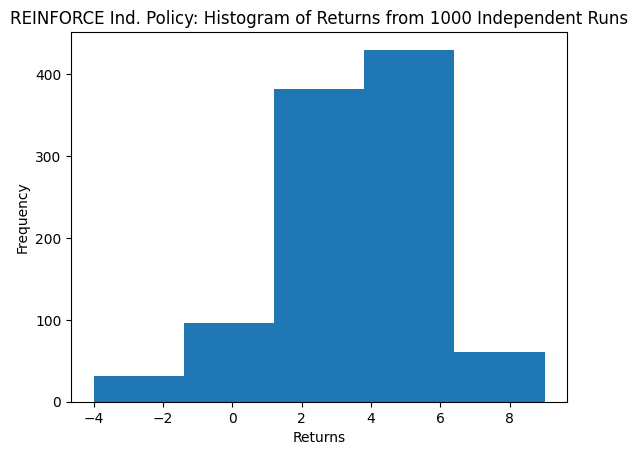

In [33]:
plt.hist(V, bins=5)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('REINFORCE Ind. Policy: Histogram of Returns from 1000 Independent Runs')
plt.show()